# CPSC 330 Lecture 4

### Lecture plan

- Announcements
- Vectors, distances, neighbours (20 min)
- KNN for supervised learning (25 min)
- Break (5 min)
- Feature scaling (15 min)
- The "Golden Rule" (10 min)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
plt.rcParams['font.size'] = 16

## Vectors, distances, neighbours (20 min)

#### Distances between points

- First, we need to talk a bit about vectors and distances.
- Let's return to to the cities dataset from the beginning of the course.

In [22]:
cities_df = pd.read_csv('data/cities_USA.csv', index_col=0)

In [23]:
blue = cities_df.query('vote == "blue"')
red  = cities_df.query('vote == "red"')

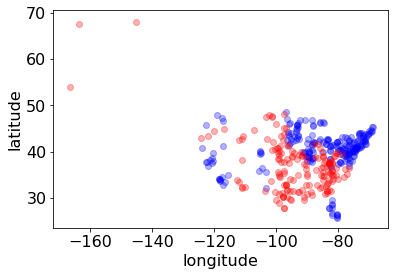

In [24]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.ylabel("latitude");
plt.xlabel("longitude");

Let's take 2 points:

In [25]:
two_cities = cities_df.sample(2, random_state=30).drop(columns=['vote'])

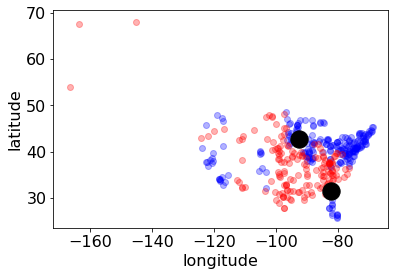

In [26]:
plt.scatter(blue["lon"], blue["lat"], color="blue", alpha=0.3);
plt.scatter(red["lon"], red["lat"], color="red", alpha=0.3);
plt.scatter(two_cities["lon"], two_cities["lat"], color="black", s=300);
plt.ylabel("latitude");
plt.xlabel("longitude");

- For the cities at the two big cicles, what is the _distance_ between them?

In [27]:
two_cities

,lon,lat
36,-82.249594,31.402780
317,-92.341701,42.673137


Subtract the two cities:

In [28]:
two_cities.iloc[1] - two_cities.iloc[0]

lon   -10.092107
lat    11.270357
dtype: float64

Square the differences:

In [29]:
(two_cities.iloc[1] - two_cities.iloc[0])**2

lon    101.850624
lat    127.020947
dtype: float64

Sum them up:

In [30]:
np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2)

228.8715706068982

Take the square root:

In [31]:
np.sqrt(np.sum((two_cities.iloc[1] - two_cities.iloc[0])**2))

15.128501928707223

The above is called the Euclidean distance. 

In [32]:
sklearn.metrics.pairwise.euclidean_distances(two_cities)

array([[ 0.        , 15.12850193],
       [15.12850193,  0.        ]])

#### Finding the nearest neighbour

We can find the closest cities to City 0:

In [33]:
dists = sklearn.metrics.pairwise.euclidean_distances(cities_df[["lat", "lon"]])
dists

array([[ 0.        ,  0.25726537,  0.54650006, ..., 90.84357803,
        93.51968715, 77.8168621 ],
       [ 0.25726537,  0.        ,  0.31414736, ..., 90.71632405,
        93.36044603, 77.63631694],
       [ 0.54650006,  0.31414736,  0.        , ..., 90.74184686,
        93.33882475, 77.58040549],
       ...,
       [90.84357803, 90.71632405, 90.74184686, ...,  0.        ,
        14.0576291 , 25.4251158 ],
       [93.51968715, 93.36044603, 93.33882475, ..., 14.0576291 ,
         0.        , 18.31512614],
       [77.8168621 , 77.63631694, 77.58040549, ..., 25.4251158 ,
        18.31512614,  0.        ]])

In [34]:
dists.shape

(400, 400)

In [35]:
cities_df.shape

(400, 3)

These are the distances between City 0 and all other cities:

In [36]:
dists[0][:10]

array([ 0.        ,  0.25726537,  0.54650006,  0.60587695,  1.75469731,
        0.76859092,  1.97778941,  2.61609123,  3.28633296, 17.38999653])

We can find the smallest with `np.argmin`:

In [37]:
np.argmin(dists[0])

0

Whoops, that just says city 0 is closest to city 0...

In [38]:
np.fill_diagonal(dists, np.inf)
dists

array([[        inf,  0.25726537,  0.54650006, ..., 90.84357803,
        93.51968715, 77.8168621 ],
       [ 0.25726537,         inf,  0.31414736, ..., 90.71632405,
        93.36044603, 77.63631694],
       [ 0.54650006,  0.31414736,         inf, ..., 90.74184686,
        93.33882475, 77.58040549],
       ...,
       [90.84357803, 90.71632405, 90.74184686, ...,         inf,
        14.0576291 , 25.4251158 ],
       [93.51968715, 93.36044603, 93.33882475, ..., 14.0576291 ,
                inf, 18.31512614],
       [77.8168621 , 77.63631694, 77.58040549, ..., 25.4251158 ,
        18.31512614,         inf]])

In [39]:
np.argmin(dists[0])

1

Ok, so the closest city to City 0 is City 1. 

#### Finding the distances to a query point

We can also find the distances to a new "test" or "query" city:

In [40]:
dists = sklearn.metrics.pairwise.euclidean_distances(cities_df[["lat", "lon"]], [[0, 0]])
dists[:10]

array([[ 84.17901524],
       [ 84.30562848],
       [ 84.28113295],
       [ 84.4453635 ],
       [ 85.92913939],
       [ 84.32289429],
       [ 86.10623378],
       [ 86.36094249],
       [ 87.25286283],
       [101.30925538]])

In [41]:
np.argmin(dists)

357

Apparently City 357 is closest to the point $(0,0)$.

## KNN for supervised learning (10 min)

#### Classification

- Here is some toy data for binary classification.
- I want to predict the point in grey.

![](img/scatter.png)

- An intuitive way to do this is predict the grey point using the same label as the next "closest" point ($k = 1$)
- We would predict a target of **1 (orange)** in this case

![](img/scatter_k1.png)


- We could also use the 3 closest points ($k = 3$)...
- We would predict a target of **0 (blue)** in this case

![](img/scatter_k3.png)

Going back to the cities dataset:

In [111]:
cities_df_train, cities_df_test = train_test_split(cities_df)

In [112]:
X_train = cities_df_train.drop(columns=['vote'])
X_test = cities_df_test.drop(columns=['vote'])
y_train = cities_df_train['vote']
y_test = cities_df_test['vote']

In [113]:
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train);

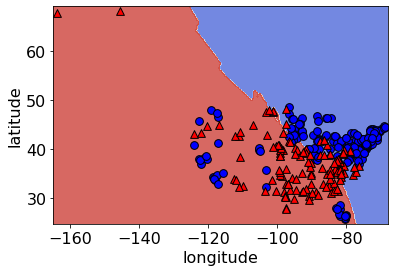

In [114]:
plot_classifier(X_train, y_train, knn, ax=plt.gca(), ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [115]:
knn.score(X_train, y_train)

0.74

In [116]:
knn.score(X_test, y_test)

0.79

- $k$ is a hyperparameter
- What happens when we play around with $k$?
  - smaller $k$: lower training error, higher approximation error.

In [117]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train);

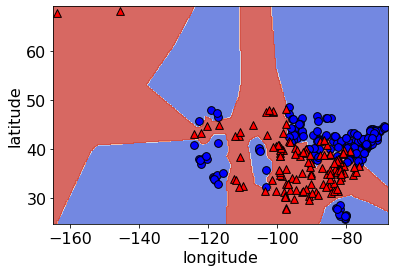

In [118]:
plot_classifier(X_train, y_train, knn, ax=plt.gca(), ticks=True);
plt.ylabel("latitude");
plt.xlabel("longitude");

In [119]:
knn.score(X_train, y_train)

1.0

In [120]:
knn.score(X_test, y_test)

0.98

- Like the RBF SVM, with KNN we can get arbitrarily high training accuracy.
- In fact the two are quite similar to each other in general.

## Regression

- In KNN regression we take the average of the $k$ nearest neighbours
- Note: regression plots more natural in 1D, classification in 2D, but of course we can do either for any $d$

In [139]:
n = 30 # number of samples
np.random.seed(0) # fix seed for reproducibility
X = np.linspace(-1,1,n)+np.random.randn(n)*0.01
X = X[:, None]
y = np.random.randn(n,1) + X*5

With $k=1$:

In [140]:
knn = KNeighborsRegressor(n_neighbors=1, weights='uniform').fit(X, y)

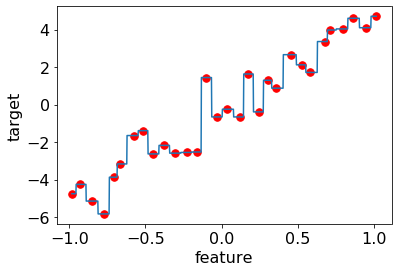

In [141]:
plt.plot(X, y, '.r', markersize=15)
grid = np.linspace(np.min(X), np.max(X), 1000)[:,None]
plt.plot(grid, knn.predict(grid));
plt.xlabel('feature');
plt.ylabel('target');

In [142]:
knn.score(X, y)

1.0

And with $k=10$:

In [147]:
knn = KNeighborsRegressor(n_neighbors=10, weights='uniform').fit(X, y)

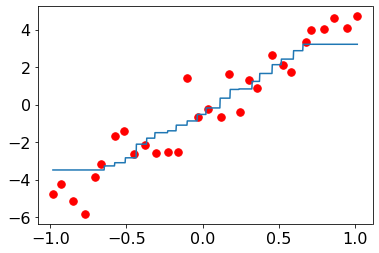

In [148]:
plt.plot(X, y, '.r', markersize=15)
plt.plot(grid, knn.predict(grid));

In [149]:
knn.score(X, y)

0.8671815772959105

In [150]:
knn = KNeighborsRegressor(n_neighbors=10, weights='distance').fit(X, y)

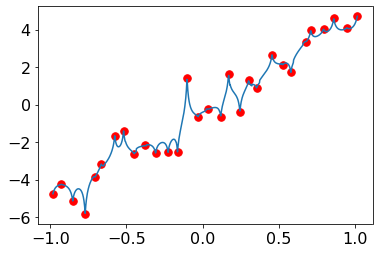

In [151]:
plt.plot(X, y, '.r', markersize=15)
plt.plot(grid, knn.predict(grid));

- So, we have KNN as a new supervised learning technique in our toolbox.
- It can be used for classification or regression (much like the other methods we've seen).
- It works by finding the $k$ closest neighbours to a given "query point".
- This fundamentally relies on a choice if distance.
- sklearn's KNN methods use Euclidean distance by default, but you can set others.

#### Pros/cons of KNN for supervised learning

Pros:

- Easy to understand, interpret.
- Simply hyperparameter controlling the fundamental tradeoff.
- Can learn very complex functions given enough data.

Cons:

- Can be potentially be VERY slow.
- Often not that great test accuracy.

Note: for regular KNN for supervised learning (not with sparse matrices), you should scale your features.

## Break (5 min)

## The "Golden Rule" (10 min)

- Previously, we used our validation set to inform our choice of the least overfit model.
- Is this okay? It can be, if we don't do this too many times.
- If we use it too many times, we suffer from "optimization bias".
- We've been talking about 2 sets, but there are often 3:
    - Training: used to learn the model
    - Validation: used to tune the model (e.g., hyperparameters)
    - Test: used to evaluate the model (lock it in a "vault" until you're ready to evaluate)
    - e.g., see [here](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7).

- The "golden rule" is that we need to be extremely vigilant about what data is being used for what.
- A test set should only be used "once".  
  - Even if only used once, it won't be a perfect representation of deployment error:

1. Bad luck (which gets worse if it's a smaller set of data)
2. The deployment data comes from a different distribution
3. And if it's used more than once, then you have another problem, which is that it influenced training and is no longer "unseen data".

Avoid this 3rd issue! The other two are bad enough.